In [3]:
import torch
import matplotlib.pyplot as plt
import os
import imageio
import datasets.toy_datasets as datasets

import utils.sde_lib as SDEs
from utils.models import MatrixTimeEmbedding, MLP
from utils.model_utils import get_preconditioned_model
from utils.metrics import get_w2

torch.set_printoptions(precision=4,sci_mode=False)

In [16]:
# SB 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = f'./checkpoints/vdsm/itr_100000'
# model_path = f'./checkpoints/board-momentum/itr_11000'
forward_score  = MatrixTimeEmbedding([2]).to(device)
mom_score = MLP(2,False).to(device)
forward_score.load_state_dict(torch.load(os.path.join(model_path,'forward_ema.pt')))
mom_score.load_state_dict(torch.load(os.path.join(model_path,'backward.pt')))

linear_sb = SDEs.LinearSchrodingerBridge(forward_model=forward_score)
linear_sb.backward_score = get_preconditioned_model(mom_score, linear_sb)

vp = SDEs.VP()
vp_score = MLP(2,False).to(device)
vp_score.load_state_dict(torch.load('checkpoints/vp/itr_100000/backward.pt'))
vp.backward_score = get_preconditioned_model(vp_score,vp)

print(forward_score.Lambda)

Parameter containing:
tensor([ 0.0002, -0.0011], device='cuda:0', requires_grad=True)


In [17]:
# SB 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
linear_momentum = SDEs.LinearMomentumSchrodingerBridge()

model_path = f'./checkpoints/momentum/itr_95000'
forward_score  = MatrixTimeEmbedding([4]).to(device)
mom_score = MLP(2,True).to(device)
forward_score.load_state_dict(torch.load(os.path.join(model_path,'forward_ema.pt')))
mom_score.load_state_dict(torch.load(os.path.join(model_path,'backward.pt')))

linear_momentum.backward_score = get_preconditioned_model(mom_score,linear_momentum)
linear_momentum.forward_score = forward_score


cld_score = MLP(2,True).to(device)
cld_score.load_state_dict(torch.load('checkpoints/cld/itr_100000/backward.pt'))
cld = SDEs.CLD()
cld_score = get_preconditioned_model(cld_score, cld)
cld.backward_score = cld_score

print(forward_score.Lambda)

Parameter containing:
tensor([-0.0037, -0.0040,  0.0040,  0.0038], device='cuda:0',
       requires_grad=True)


In [18]:
dataset = datasets.Spiral(x_scalar=0.4, y_scalar=3.2,batch_size=5000)
true = next(iter(dataset)).to(device)
mom_samp, _ = linear_momentum.sample((5000,4),device, n_time_pts=12)
cld_samp, _ = cld.sample((5000,4),device, n_time_pts=12)

print(get_w2(true,mom_samp[:,:2]))
print(get_w2(true,cld_samp[:,:2]))


tensor(3.6925, device='cuda:0')
tensor(2.9923, device='cuda:0')


In [19]:
def plot_trajectories(traj, save_path, gif_name='trajectories.gif'):
    idx = range(traj.shape[1])
    file_names = [os.path.join(save_path,f'{i}.png') for i in idx]
    dt = 1/(traj.shape[1]-1)
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability
    
    for i in idx:
        plt.clf()
        plt.title(f't = {dt * i : .2f}')
        plt.grid(zorder=0)
        plt.scatter(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu())
        # plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
        # plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)
        plt.xlim(-5,10)
        plt.ylim(-22, 41)

        plt.savefig(file_names[i])
    plt.clf()
    with imageio.get_writer(gif_name, mode='I', duration=0.05) as writer:
        for filename in file_names:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optional: Clean up the temporary files
    # for filename in file_names:
    #     os.remove(filename)

def plot_lines(traj, filename):
    plt.clf()
    plt.figure(figsize=(6,6))  # Increase the figure size for better readability

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', linewidth=0.5)
    for i in range(traj.shape[0]):
        xi = traj[i]
        plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

    # plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(), label='start',zorder=1010, cmap='viridis', s=10, alpha=0.75)
    plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
    # plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
    # plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)
    plt.xlim(-5,10)
    plt.ylim(-22, 41)

    plt.legend()
    plt.savefig(filename,facecolor='none', edgecolor='none', transparent=True)
    
def create_all_figs(sde : SDEs.SDE,type):
    n_samples = 50
    true_samples = dataset.__next__(n_samples * 5)
    samples, traj = sde.sample((n_samples,4),device,prob_flow=False,return_traj=True,n_time_pts=25)
    # cld_samp, traj_cld = sdes[1].sample((n_samples,4),device,prob_flow=False, return_traj=True, n_time_pts=25)
    # Create the plot
    plt.figure(figsize=(6, 6))  # Increase the figure size for better readability
    plt.scatter(true_samples[:,0].cpu(), true_samples[:,1].cpu(), s=10, alpha=0.75,label='true')  # Use colormap, adjust size and transparency
    # plt.scatter(cld_samp[:,0].cpu(), cld_samp[:,1].cpu(), s=10, alpha=0.75, label='cld')  # Use colormap, adjust size and transparency
    plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=10, alpha=0.75, label='generated')  # Use colormap, adjust size and transparency

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Adjust the axis limits if needed
    plt.xlim(-5,10)
    plt.ylim(-22, 41)
    # plt.xlim(samples[:,0].cpu().min()-0.5, samples[:,0].cpu().max()+0.5)
    # plt.ylim(samples[:,1].cpu().min()-0.5, samples[:,1].cpu().max()+0.5)
    plt.legend()
    # Show the plot
    plt.show()

    plot_lines(traj, f'trajectory/lines_{type}.png')
    plot_trajectories(traj,save_path=f'./trajectory/{type}/',gif_name=f'trajectory/trajectories_board_{type}.gif')

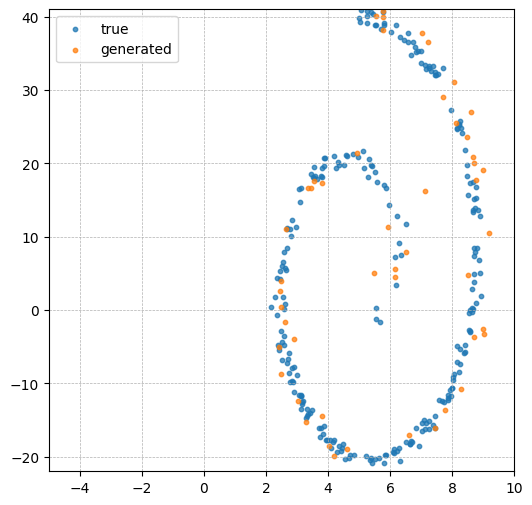

/tmp/ipykernel_7903/816549658.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
/tmp/ipykernel_7903/816549658.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

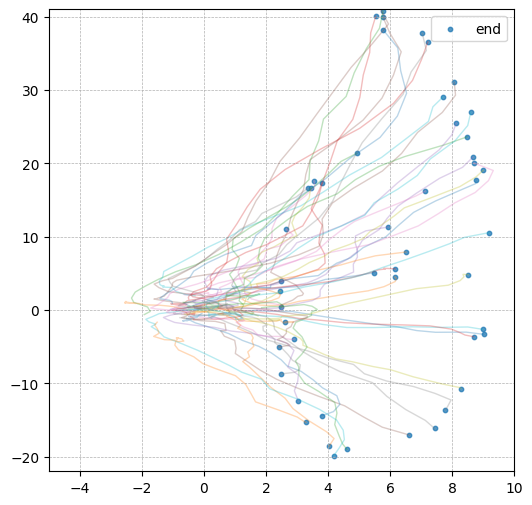

<Figure size 800x800 with 0 Axes>

In [20]:
create_all_figs(linear_momentum,'momentum')


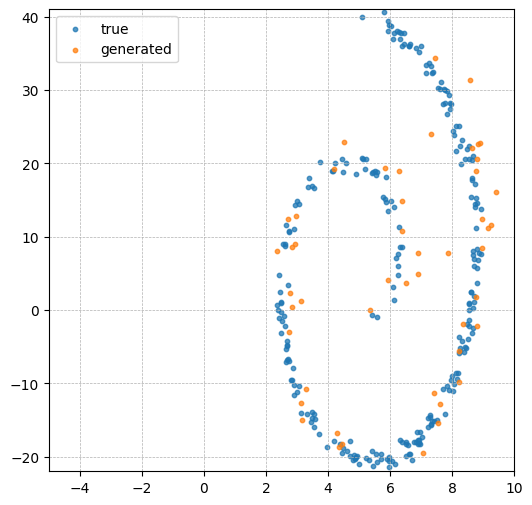

/tmp/ipykernel_7903/816549658.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
/tmp/ipykernel_7903/816549658.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

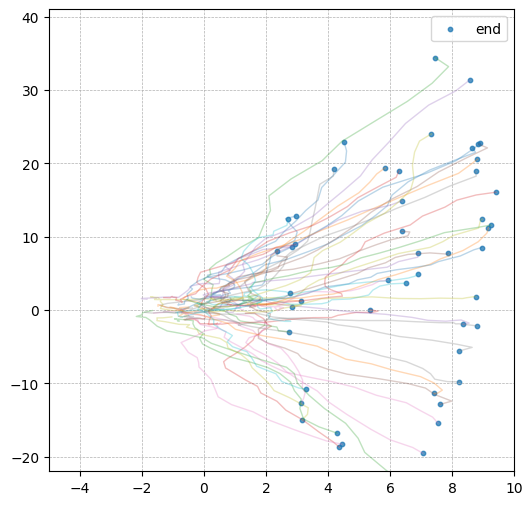

<Figure size 800x800 with 0 Axes>

In [21]:
create_all_figs(cld,'cld')

In [22]:
# n_pts = 20
# x_pts = torch.linspace(-5,5,n_pts,device=device)#.view(-1,1)
# y_pts = torch.linspace(-27,32,n_pts, device=device)#.view(-1,1)
# x_pts, y_pts = torch.meshgrid((x_pts,y_pts))
# x_pts = x_pts.reshape(-1,1)
# y_pts = y_pts.reshape(-1,1)
# z_pts = torch.cat((x_pts,y_pts),dim=-1)
# n_time = 100
# times = torch.linspace(0,1,n_time,device=device).unsqueeze(-1)
# dt = 1/n_time
# xt = dataset.sample(1000).to(device=device)
# noise = torch.randn_like(xt)
# for i,t in enumerate(times):
#     t_shape = t.expand(z_pts.shape[0]).unsqueeze(-1)
    
#     vector_field = sde.probability_flow_drift(z_pts,t_shape)
#     plt.xlim(-27,32)
#     plt.ylim(-27,32)
#     plt.quiver(x_pts.cpu(),y_pts.cpu(),vector_field[:,0].cpu(),vector_field[:,1].cpu())
#     plt.scatter(xt[:,0].cpu(), xt[:,1].cpu(),alpha=.3)
#     plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(),alpha=.1)
#     plt.savefig(f'./vector-field/{i}.png')
#     plt.clf()
#     xt = xt + sde.probability_flow_drift(xt,t.expand(xt.shape[0]).unsqueeze(-1)) * dt


In [33]:
@torch.no_grad()
def measure_straightness(sde : SDEs.LinearMomentumSchrodingerBridge, trajectories):
    start, end = trajectories[:,0], trajectories[:,-1]
    diff = end - start
    straightness = 0
    n_pts =trajectories.shape[1]
    dt = sde.T/n_pts

    time_pts = sde.T - torch.linspace(0., sde.T, n_pts, device=device)
    one = torch.ones(start.shape[0],device=start.device)
    for i in range(n_pts-1):
        drift = sde.probability_flow_drift(trajectories[:,i+1], one * (time_pts[i]))
        straightness += torch.mean(torch.sum((diff-drift)**2,dim=-1),dim=0)
    
    return straightness * dt/(trajectories.shape[-1])


n_time_pts = 500
dataset = datasets.Spiral(x_scalar=0.4, y_scalar=3.2,batch_size=5000)
true = next(iter(dataset)).to(device)
mom_samp, mom_traj = linear_momentum.sample((5000,4),device, n_time_pts=n_time_pts, return_traj=True)
cld_samp, cld_traj = cld.sample((5000,4),device, n_time_pts=n_time_pts, return_traj=True)
vdsm_samp, vdsm_traj = linear_sb.sample((5000,2),device,n_time_pts=n_time_pts,return_traj=True)
vp_samp, vp_traj = vp.sample((5000,2),device,n_time_pts=n_time_pts,return_traj=True)

print(measure_straightness(linear_momentum,mom_traj), get_w2(true,mom_samp))
print(measure_straightness(cld,cld_traj), get_w2(true,cld_samp))
print(measure_straightness(linear_sb,vdsm_traj), get_w2(true,vdsm_samp))
print(measure_straightness(vp,vp_traj), get_w2(true,vp_samp))

tensor(752.8861, device='cuda:0') tensor(3.4562, device='cuda:0')
tensor(579.9307, device='cuda:0') tensor(2.5708, device='cuda:0')
tensor(1053.6989, device='cuda:0') tensor(0.9003, device='cuda:0')
tensor(1102.8162, device='cuda:0') tensor(0.8255, device='cuda:0')


In [29]:
dataset = datasets.Spiral(x_scalar=0.4, y_scalar=3.2,batch_size=5000)

mean = 0
n = 10
for i in range(n):
    mean += next(dataset).mean(0,keepdim=True)

mean = mean/n
print(mean)

std = 0
for i in range(n):
    std+= torch.sum((next(dataset) - mean)**2,dim=0)/(4999)

std = std/n
print(std**.5)

print(next(dataset).std(dim=0))

tensor([[5.8870, 6.5272]])
tensor([ 2.0971, 18.6852])
tensor([ 2.0860, 18.6708])
